In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import matplotlib.pyplot as plt         

In [2]:

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, commission_fee=0.01, slippage_cost=0.1):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.date = data['date']
        self.stock_price_history = data['adj_close']
        self.commission_fee = commission_fee
        self.slippage_cost = slippage_cost
        
        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), shape=(2,))  # (Action, Amount) where Action: -1: Buy, 0: Hold, 1: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,))
        
        self.render_df = pd.DataFrame()
        self.done = False
        self.current_portfolio_value = initial_balance
        
    def reset(self, seed = None):
        self.current_step = 0
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.done = False
        self.current_portfolio_value = self.initial_balance
        return self._get_observation(), {}
    
    def step(self, action):
        assert self.action_space.contains(action)
        prev_portfolio_value = self.balance if self.current_step == 0 else self.balance + self.stock_owned * self.stock_price_history[self.current_step - 1]
        current_price = self.stock_price_history[self.current_step]    
        amount = int(self.initial_balance * action[1] / current_price)
    
        if action[0] > 0:  # Buy
            amount =  min( int(self.initial_balance * action[1] / current_price), int(self.balance / current_price * (1 + self.commission_fee + self.slippage_cost)))
            if self.balance >= current_price * amount * (1 + self.commission_fee + self.slippage_cost):
                self.stock_owned += amount
                self.balance -= current_price * amount * (1 + self.commission_fee + self.slippage_cost)
        elif action[0] < 0:  # Sell
            amount = min(amount, self.stock_owned)
            if self.stock_owned > 0:
                self.stock_owned -= amount
                self.balance += current_price * amount * (1 - self.commission_fee - self.slippage_cost)
        
        current_portfolio_value = self.balance + self.stock_owned * current_price
        excess_return = current_portfolio_value - prev_portfolio_value 
        risk_free_rate = 0.02  # Example risk-free rate
        std_deviation = np.std(self.stock_price_history[:self.current_step + 1])
        sharpe_ratio = (excess_return - risk_free_rate) / std_deviation if std_deviation != 0 else 0
        reward = sharpe_ratio
         
        self.render(action, amount, current_portfolio_value)
        obs = self._get_observation()
        
        self.current_step += 1
        
        if self.current_step == len(self.data['adj_close']):
            done = True
        else:
            done = False
        
        self.done = done

        info = {}  
        return obs, reward, done, False,info
    
    
    def _get_observation(self):
        return np.array([
            self.stock_price_history[self.current_step]
        ])
    
    def render(self, action, amount, current_portfolio_value, mode = None):
        current_date = self.date[self.current_step]
        today_action =  'buy' if action[0] > 0 else 'sell'
        current_price = self.stock_price_history[self.current_step]
        
        if mode == 'human':
            print(f"Step:{self.current_step}, Date: {current_date}, Market Value: {current_portfolio_value:.2f}, Balance: {self.balance:.2f}, Stock Owned: {self.stock_owned}, Stock Price: {current_price:.2f}, Today Action: {today_action}:{amount}")
        else:
            pass
        dict = {
            'Date': [current_date], 'market_value': [current_portfolio_value], 'balance': [self.balance], 'stock_owned': [self.stock_owned], 'price': [current_price], 'action': [today_action], 'amount':[amount]
        }
        step_df = pd.DataFrame.from_dict(dict)
        self.render_df = pd.concat([self.render_df, step_df], ignore_index=True)
    
    def render_all(self):
        df = self.render_df.set_index('Date')       
        fig, ax = plt.subplots(figsize=(18, 6)) 
        df.plot( y="market_value" , use_index=True,  ax = ax, style='--' , color='lightgrey') 
        df.plot( y="price" , use_index=True,  ax = ax , secondary_y = True , color='black')
         
        for idx in df.index.tolist():
            if (df.loc[idx]['action'] == 'buy') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] - 1,
                    'g^'
                )
                plt.text(idx, df.loc[idx]["price"]- 3, df.loc[idx]['amount'] , c= 'green',fontsize=8, horizontalalignment='center', verticalalignment='center')
            elif (df.loc[idx]['action'] == 'sell') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] + 1,
                    'rv'
                    )
                plt.text(idx, df.loc[idx]["price"] + 3, df.loc[idx]['amount'], c= 'red',fontsize=8, horizontalalignment='center', verticalalignment='center')

In [3]:
from pybroker import YFinance
import pybroker
pybroker.enable_data_source_cache('yfinance')
from stable_baselines3 import PPO

In [ ]:
yfinance = YFinance()
dftrain = yfinance.query(['AAPL'], start_date='3/1/2021', end_date='3/1/2022')
dftrain['date'] = pd.to_datetime(dftrain['date']).dt.date

Loaded cached bar data.



In [ ]:
dftrain

,date,symbol,open,high,low,close,volume,adj_close
0,2021-03-01,AAPL,123.750000,127.930000,122.790001,127.790001,116307900,125.146828
1,2021-03-02,AAPL,128.410004,128.720001,125.010002,125.120003,102260900,122.532043
2,2021-03-03,AAPL,124.809998,125.709999,121.839996,122.059998,112966300,119.535324
3,2021-03-04,AAPL,121.750000,123.599998,118.620003,120.129997,178155000,117.645264
4,2021-03-05,AAPL,120.980003,121.940002,117.570000,121.419998,153766600,118.908569
...,...,...,...,...,...,...,...,...
248,2022-02-22,AAPL,164.979996,166.690002,162.149994,164.320007,91162800,161.877701
249,2022-02-23,AAPL,165.539993,166.149994,159.750000,160.070007,90009200,157.690872
250,2022-02-24,AAPL,152.580002,162.850006,152.000000,162.740005,141147500,160.321167
251,2022-02-25,AAPL,163.839996,165.119995,160.869995,164.850006,91974200,162.399796


C:\Users\Yatharth Jain\AppData\Local\Temp\ipykernel_16640\2854125423.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


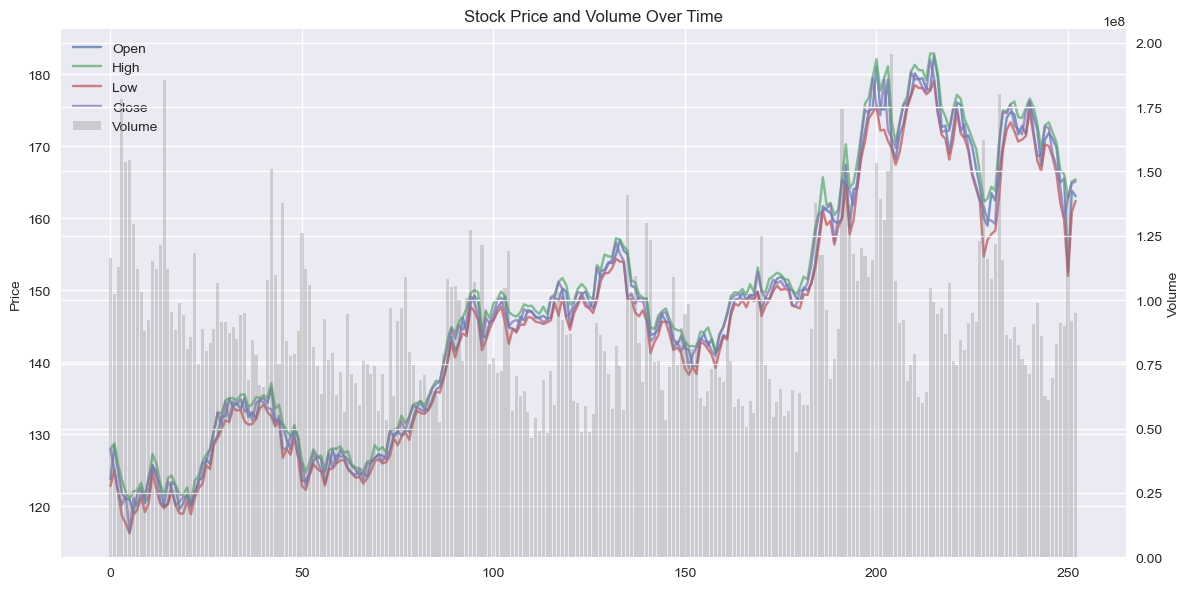

In [ ]:
import seaborn as sns

# Set style
plt.style.use('seaborn')

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot OHLC on primary axis
ax1.plot(dftrain.index, dftrain['open'], label='Open', alpha=0.7)
ax1.plot(dftrain.index, dftrain['high'], label='High', alpha=0.7)
ax1.plot(dftrain.index, dftrain['low'], label='Low', alpha=0.7)
ax1.plot(dftrain.index, dftrain['close'], label='Close', alpha=0.7)
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create secondary axis for volume
ax2 = ax1.twinx()
ax2.bar(dftrain.index, dftrain['volume'], alpha=0.3, color='gray', label='Volume')
ax2.set_ylabel('Volume')

# Format
plt.title('Stock Price and Volume Over Time - Training Data')
plt.xticks(rotation=45)

# Show both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [8]:
env = StockTradingEnv(dftrain, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=100_000, progress_bar=True)
model.save("ppo_aapl")

Output()

In [9]:
yfinance = YFinance()
dftest = yfinance.query(['AAPL'], start_date='3/1/2022', end_date='3/1/2023')
dftest['date'] = pd.to_datetime(dftest['date']).dt.date
dftest


Loading bar data...


[*********************100%***********************]  1 of 1 completed

Loaded bar data: 0:00:01 



,date,symbol,open,high,low,close,volume,adj_close
0,2022-03-01,AAPL,164.699997,166.600006,161.970001,163.199997,83474400,160.774338
1,2022-03-02,AAPL,164.389999,167.360001,162.949997,166.559998,79724800,164.084366
2,2022-03-03,AAPL,168.470001,168.910004,165.550003,166.229996,76678400,163.759293
3,2022-03-04,AAPL,164.490005,165.550003,162.100006,163.169998,83737200,160.744766
4,2022-03-07,AAPL,163.360001,165.020004,159.039993,159.300003,96418800,156.932312
...,...,...,...,...,...,...,...,...
246,2023-02-22,AAPL,148.869995,149.949997,147.160004,148.910004,51011300,147.585358
247,2023-02-23,AAPL,150.089996,150.339996,147.240005,149.399994,48394200,148.070984
248,2023-02-24,AAPL,147.110001,147.190002,145.720001,146.710007,55469600,145.404938
249,2023-02-27,AAPL,147.710007,149.169998,147.449997,147.919998,44998500,146.604172


C:\Users\Yatharth Jain\AppData\Local\Temp\ipykernel_16640\3280022576.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


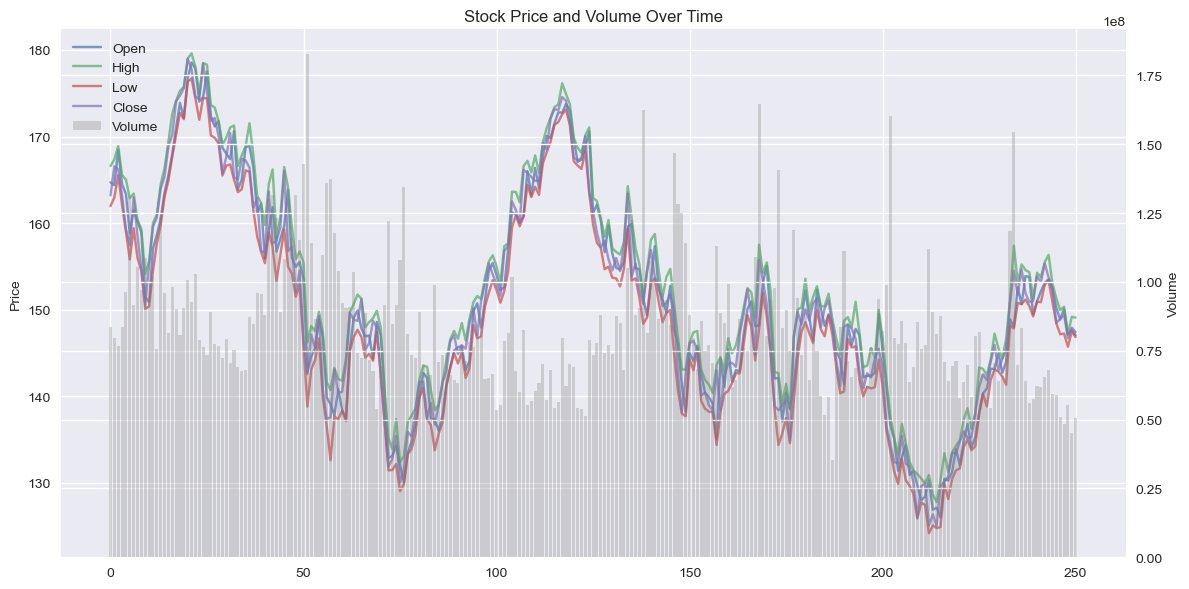

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn')

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot OHLC on primary axis
ax1.plot(dftest.index, dftest['open'], label='Open', alpha=0.7)
ax1.plot(dftest.index, dftest['high'], label='High', alpha=0.7)
ax1.plot(dftest.index, dftest['low'], label='Low', alpha=0.7)
ax1.plot(dftest.index, dftest['close'], label='Close', alpha=0.7)
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create secondary axis for volume
ax2 = ax1.twinx()
ax2.bar(dftest.index, dftest['volume'], alpha=0.3, color='gray', label='Volume')
ax2.set_ylabel('Volume')

# Format
plt.title('Stock Price and Volume Over Time')
plt.xticks(rotation=45)

# Show both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

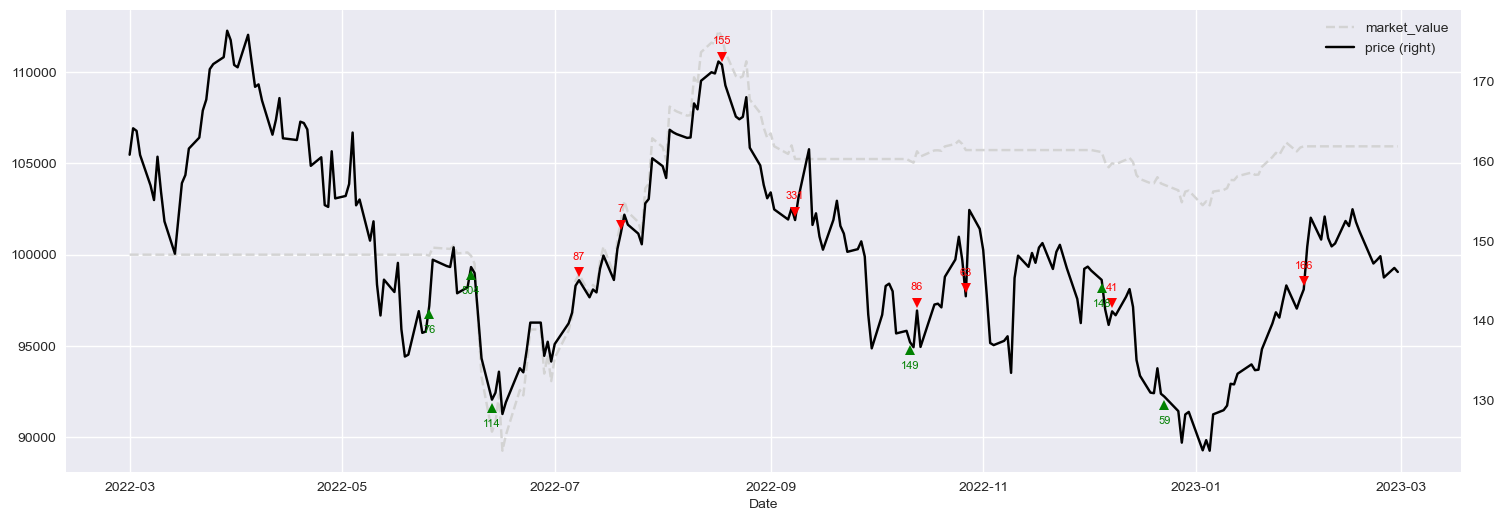

In [12]:
env = StockTradingEnv(dftest, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)

model = PPO.load("ppo_aapl", env=env)

vec_env = model.get_env()
obs = vec_env.reset()
for i in range(len(dftest['adj_close'])):
    action, _state = model.predict(obs)
    obs, reward, done, info = vec_env.step(action)

env.render_all()